In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib

from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader, Dataset
from matplotlib import pyplot as plt
from tqdm import tqdm

matplotlib.style.use('ggplot')

In [ ]:
# config
batch_size = 512
epochs = 200
sample_size = 64 # fixed sample size
nz = 100 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
data_dir = 'NewCats'

train_data=datasets.ImageFolder(root=data_dir, transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), transforms.Grayscale(num_output_channels=1)
                           ]))

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

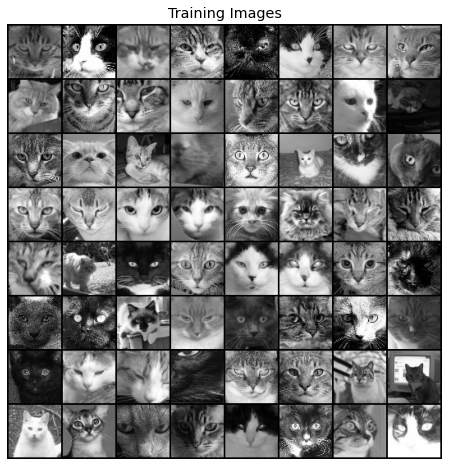

In [ ]:
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            # state size. (64*8) x 4 x 4
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            # state size. (64*4) x 8 x 8
            nn.ConvTranspose2d( 64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            # state size. (64*2) x 16 x 16
            nn.ConvTranspose2d( 64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # state size. (64) x 32 x 32
            nn.ConvTranspose2d( 64, 1, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, x):
        return self.main(x)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            # input is (3) x 64 x 64
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (64) x 32 x 32
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (64*2) x 16 x 16
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (64*2) x 16 x 16
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (64*8) x 4 x 4
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.main(x)

In [ ]:
generator = Generator().to(device)
generator.apply(weights_init)
discriminator = Discriminator().to(device)
discriminator.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [ ]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5,0.999))
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5,0.999))

In [ ]:
# loss function
criterion = nn.BCELoss()

In [ ]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch

In [ ]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones((size,))
    return data.to(device)
    
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros((size,))
    return data.to(device)

In [ ]:
# function to train the discriminator network
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    real_label = label_real(b_size)
    fake_label = label_fake(b_size)
    optimizer.zero_grad()
    output_real = discriminator(data_real).view(-1)
    loss_real = criterion(output_real, real_label)
    output_fake = discriminator(data_fake).view(-1)
    loss_fake = criterion(output_fake, fake_label)
    loss_real.backward()
    loss_fake.backward()
    optimizer.step()
    return loss_real + loss_fake

In [ ]:
# function to train the generator network
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    real_label = label_real(b_size)
    optimizer.zero_grad()
    output = discriminator(data_fake).view(-1)
    loss = criterion(output, real_label)
    loss.backward()
    optimizer.step()
    return loss

In [ ]:
reference_noise = torch.randn(64, nz, 1, 1).to(device)

In [ ]:
for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        # run the discriminator for k number of steps
        for step in range(k):
            data_fake = generator(torch.randn(b_size, nz, 1, 1).to(device)).detach()
            data_real = image
            # train the discriminator network
            loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(torch.randn(b_size, nz, 1, 1).to(device))
        # train the generator network
        loss_g += train_generator(optim_g, data_fake)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)

    #saving a reference image
    results = generator(reference_noise).detach()
    results = make_grid(results)
    save_image(results, f"outputs/result_{epoch}.png")
    
    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")


100%|██████████| 58/58 [00:59<00:00,  1.01s/it]
59it [01:00,  1.02s/it]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 0 of 200
Generator loss: 12.70817947, Discriminator loss: 0.83814377



100%|██████████| 58/58 [00:58<00:00,  1.02s/it]
59it [00:59,  1.00s/it]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 1 of 200
Generator loss: 3.63855243, Discriminator loss: 0.79623413



100%|██████████| 58/58 [00:58<00:00,  1.01s/it]
59it [00:59,  1.00s/it]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 2 of 200
Generator loss: 3.73878813, Discriminator loss: 0.61767894



100%|██████████| 58/58 [00:58<00:00,  1.00s/it]
59it [00:59,  1.00s/it]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 3 of 200
Generator loss: 4.28464127, Discriminator loss: 0.68312418



100%|██████████| 58/58 [00:58<00:00,  1.01s/it]
59it [00:58,  1.00it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 4 of 200
Generator loss: 3.95542145, Discriminator loss: 0.82396311



100%|██████████| 58/58 [00:58<00:00,  1.01s/it]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 5 of 200
Generator loss: 3.98520350, Discriminator loss: 0.70339710



100%|██████████| 58/58 [00:58<00:00,  1.01s/it]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 6 of 200
Generator loss: 4.10700417, Discriminator loss: 0.60479861



100%|██████████| 58/58 [00:57<00:00,  1.00s/it]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 7 of 200
Generator loss: 4.47547483, Discriminator loss: 0.59804273



100%|██████████| 58/58 [00:58<00:00,  1.00it/s]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 8 of 200
Generator loss: 4.66707420, Discriminator loss: 0.70313114



100%|██████████| 58/58 [00:58<00:00,  1.00it/s]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 9 of 200
Generator loss: 4.44832945, Discriminator loss: 0.74826360



100%|██████████| 58/58 [00:57<00:00,  1.01it/s]
59it [00:58,  1.02it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 10 of 200
Generator loss: 4.47077417, Discriminator loss: 0.84996849



100%|██████████| 58/58 [00:57<00:00,  1.00s/it]
59it [00:57,  1.02it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 11 of 200
Generator loss: 4.33396816, Discriminator loss: 0.86773247



100%|██████████| 58/58 [00:57<00:00,  1.01it/s]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 12 of 200
Generator loss: 3.86414766, Discriminator loss: 0.82710207



100%|██████████| 58/58 [00:57<00:00,  1.01it/s]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 13 of 200
Generator loss: 3.96323013, Discriminator loss: 0.80551171



100%|██████████| 58/58 [00:57<00:00,  1.01it/s]
59it [00:57,  1.02it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 14 of 200
Generator loss: 3.66263413, Discriminator loss: 0.80314440



100%|██████████| 58/58 [00:57<00:00,  1.00it/s]
59it [00:58,  1.02it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 15 of 200
Generator loss: 3.61511445, Discriminator loss: 0.74345136



100%|██████████| 58/58 [00:57<00:00,  1.00it/s]
59it [00:58,  1.02it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 16 of 200
Generator loss: 3.71821356, Discriminator loss: 0.81916445



100%|██████████| 58/58 [00:57<00:00,  1.01it/s]
59it [00:58,  1.02it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 17 of 200
Generator loss: 3.90380645, Discriminator loss: 0.64769047



100%|██████████| 58/58 [00:57<00:00,  1.00it/s]
59it [00:58,  1.02it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 18 of 200
Generator loss: 3.63150835, Discriminator loss: 0.78553879



100%|██████████| 58/58 [00:57<00:00,  1.01it/s]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 19 of 200
Generator loss: 3.79482794, Discriminator loss: 0.68766928



100%|██████████| 58/58 [00:57<00:00,  1.00it/s]
59it [00:58,  1.02it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 20 of 200
Generator loss: 3.79627061, Discriminator loss: 0.72045428



100%|██████████| 58/58 [00:57<00:00,  1.00it/s]
59it [00:58,  1.02it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 21 of 200
Generator loss: 3.75608134, Discriminator loss: 0.64370072



100%|██████████| 58/58 [00:58<00:00,  1.02s/it]
59it [00:59,  1.00s/it]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 22 of 200
Generator loss: 3.82734132, Discriminator loss: 0.73824829



100%|██████████| 58/58 [00:58<00:00,  1.00it/s]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 23 of 200
Generator loss: 3.75996065, Discriminator loss: 0.56322926



100%|██████████| 58/58 [00:58<00:00,  1.01s/it]
59it [00:59,  1.00s/it]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 24 of 200
Generator loss: 3.59612894, Discriminator loss: 0.64938444



100%|██████████| 58/58 [00:57<00:00,  1.00s/it]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 25 of 200
Generator loss: 3.60932589, Discriminator loss: 0.56903708



100%|██████████| 58/58 [00:58<00:00,  1.00s/it]
59it [00:58,  1.00it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 26 of 200
Generator loss: 3.60603023, Discriminator loss: 0.73155397



100%|██████████| 58/58 [00:58<00:00,  1.00s/it]
59it [00:59,  1.00s/it]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 27 of 200
Generator loss: 3.46855998, Discriminator loss: 0.52721006



100%|██████████| 58/58 [00:58<00:00,  1.01s/it]
59it [00:58,  1.00it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 28 of 200
Generator loss: 3.68974066, Discriminator loss: 0.62228513



100%|██████████| 58/58 [00:58<00:00,  1.00it/s]
59it [00:59,  1.00s/it]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 29 of 200
Generator loss: 3.72337198, Discriminator loss: 0.69061649



100%|██████████| 58/58 [00:57<00:00,  1.03it/s]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 30 of 200
Generator loss: 3.56265831, Discriminator loss: 0.65199792



100%|██████████| 58/58 [00:56<00:00,  1.01it/s]
59it [00:57,  1.03it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 31 of 200
Generator loss: 3.52472401, Discriminator loss: 0.61857963



100%|██████████| 58/58 [00:56<00:00,  1.03it/s]
59it [00:56,  1.04it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 32 of 200
Generator loss: 3.34851599, Discriminator loss: 0.75082147



100%|██████████| 58/58 [00:58<00:00,  1.00it/s]
59it [00:59,  1.01s/it]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 33 of 200
Generator loss: 3.34768534, Discriminator loss: 0.71919090



100%|██████████| 58/58 [00:58<00:00,  1.01s/it]
59it [00:58,  1.00it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 34 of 200
Generator loss: 3.37373877, Discriminator loss: 0.67001134



100%|██████████| 58/58 [00:58<00:00,  1.02s/it]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 35 of 200
Generator loss: 3.61494994, Discriminator loss: 0.63630688



100%|██████████| 58/58 [00:58<00:00,  1.02s/it]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 36 of 200
Generator loss: 3.35570979, Discriminator loss: 0.72652322



100%|██████████| 58/58 [00:58<00:00,  1.01s/it]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 37 of 200
Generator loss: 3.38654852, Discriminator loss: 0.74252826



100%|██████████| 58/58 [00:58<00:00,  1.00it/s]
59it [00:58,  1.00it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 38 of 200
Generator loss: 3.28625941, Discriminator loss: 0.69467282



100%|██████████| 58/58 [00:57<00:00,  1.00it/s]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 39 of 200
Generator loss: 3.41664362, Discriminator loss: 0.70759070



100%|██████████| 58/58 [00:57<00:00,  1.02s/it]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 40 of 200
Generator loss: 3.15903521, Discriminator loss: 0.61962199



100%|██████████| 58/58 [00:58<00:00,  1.01s/it]
59it [00:58,  1.00it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 41 of 200
Generator loss: 3.20530295, Discriminator loss: 0.68907160



100%|██████████| 58/58 [00:58<00:00,  1.00s/it]
59it [00:58,  1.00it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 42 of 200
Generator loss: 3.13422513, Discriminator loss: 0.62770271



100%|██████████| 58/58 [00:58<00:00,  1.01s/it]
59it [00:58,  1.00it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 43 of 200
Generator loss: 3.20899272, Discriminator loss: 0.78459406



100%|██████████| 58/58 [00:58<00:00,  1.00s/it]
59it [00:59,  1.00s/it]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 44 of 200
Generator loss: 3.28083467, Discriminator loss: 0.64067900



100%|██████████| 58/58 [00:58<00:00,  1.01s/it]
59it [00:58,  1.00it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 45 of 200
Generator loss: 3.34051061, Discriminator loss: 0.77521855



100%|██████████| 58/58 [00:58<00:00,  1.04s/it]
59it [00:59,  1.00s/it]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 46 of 200
Generator loss: 3.17121387, Discriminator loss: 0.69236958



100%|██████████| 58/58 [00:58<00:00,  1.01s/it]
59it [00:59,  1.01s/it]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 47 of 200
Generator loss: 3.19831920, Discriminator loss: 0.57510185



100%|██████████| 58/58 [00:58<00:00,  1.00it/s]
59it [00:58,  1.00it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 48 of 200
Generator loss: 3.15301108, Discriminator loss: 0.66120452



100%|██████████| 58/58 [00:58<00:00,  1.00it/s]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 49 of 200
Generator loss: 3.28979015, Discriminator loss: 0.69074452



100%|██████████| 58/58 [00:57<00:00,  1.00it/s]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 50 of 200
Generator loss: 3.31700993, Discriminator loss: 0.68742651



100%|██████████| 58/58 [00:57<00:00,  1.01it/s]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 51 of 200
Generator loss: 3.21589875, Discriminator loss: 0.55934262



100%|██████████| 58/58 [00:57<00:00,  1.00it/s]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 52 of 200
Generator loss: 3.33142662, Discriminator loss: 0.70643699



100%|██████████| 58/58 [00:57<00:00,  1.01s/it]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 53 of 200
Generator loss: 3.22489667, Discriminator loss: 0.58977914



100%|██████████| 58/58 [00:57<00:00,  1.01it/s]
59it [00:58,  1.02it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 54 of 200
Generator loss: 3.25631380, Discriminator loss: 0.72650975



100%|██████████| 58/58 [00:57<00:00,  1.00it/s]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 55 of 200
Generator loss: 3.03353715, Discriminator loss: 0.53523362



100%|██████████| 58/58 [00:57<00:00,  1.00it/s]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 56 of 200
Generator loss: 3.22981763, Discriminator loss: 0.69195777



100%|██████████| 58/58 [00:57<00:00,  1.00s/it]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 57 of 200
Generator loss: 3.21309495, Discriminator loss: 0.59525633



100%|██████████| 58/58 [00:58<00:00,  1.01s/it]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 58 of 200
Generator loss: 3.12609577, Discriminator loss: 0.64522684



100%|██████████| 58/58 [00:58<00:00,  1.00it/s]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 59 of 200
Generator loss: 3.22276902, Discriminator loss: 0.91274112



100%|██████████| 58/58 [00:57<00:00,  1.00s/it]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 60 of 200
Generator loss: 2.97623706, Discriminator loss: 0.70145208



100%|██████████| 58/58 [00:57<00:00,  1.00s/it]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 61 of 200
Generator loss: 2.99106812, Discriminator loss: 0.51095575



100%|██████████| 58/58 [00:57<00:00,  1.01it/s]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 62 of 200
Generator loss: 3.09880781, Discriminator loss: 0.59952313



100%|██████████| 58/58 [00:58<00:00,  1.00it/s]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 63 of 200
Generator loss: 3.25892615, Discriminator loss: 0.70541245



100%|██████████| 58/58 [00:58<00:00,  1.01it/s]
59it [00:58,  1.00it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 64 of 200
Generator loss: 2.99934626, Discriminator loss: 0.54976016



100%|██████████| 58/58 [00:57<00:00,  1.02it/s]
59it [00:57,  1.02it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 65 of 200
Generator loss: 2.95379400, Discriminator loss: 0.54592502



100%|██████████| 58/58 [00:57<00:00,  1.02it/s]
59it [00:57,  1.02it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 66 of 200
Generator loss: 3.18745589, Discriminator loss: 0.58442253



100%|██████████| 58/58 [00:57<00:00,  1.01it/s]
59it [00:57,  1.02it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 67 of 200
Generator loss: 3.09577179, Discriminator loss: 0.78785729



100%|██████████| 58/58 [00:57<00:00,  1.01it/s]
59it [00:58,  1.02it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 68 of 200
Generator loss: 3.05270147, Discriminator loss: 0.93126154



100%|██████████| 58/58 [00:57<00:00,  1.01it/s]
59it [00:57,  1.02it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 69 of 200
Generator loss: 2.94423318, Discriminator loss: 0.52901477



100%|██████████| 58/58 [00:57<00:00,  1.01it/s]
59it [00:57,  1.02it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 70 of 200
Generator loss: 2.92183948, Discriminator loss: 0.89228749



100%|██████████| 58/58 [00:57<00:00,  1.02it/s]
59it [00:57,  1.02it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 71 of 200
Generator loss: 2.93101835, Discriminator loss: 0.63939846



100%|██████████| 58/58 [00:57<00:00,  1.00it/s]
59it [00:57,  1.02it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 72 of 200
Generator loss: 2.89908719, Discriminator loss: 0.55610228



100%|██████████| 58/58 [00:57<00:00,  1.01it/s]
59it [00:57,  1.02it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 73 of 200
Generator loss: 2.85265422, Discriminator loss: 0.52563655



100%|██████████| 58/58 [00:57<00:00,  1.01it/s]
59it [00:57,  1.02it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 74 of 200
Generator loss: 2.91732764, Discriminator loss: 0.55798751



100%|██████████| 58/58 [00:57<00:00,  1.01it/s]
59it [00:57,  1.02it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 75 of 200
Generator loss: 2.78542495, Discriminator loss: 0.80974919



100%|██████████| 58/58 [00:57<00:00,  1.02it/s]
59it [00:57,  1.02it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 76 of 200
Generator loss: 2.85772419, Discriminator loss: 0.53772235



100%|██████████| 58/58 [00:57<00:00,  1.02it/s]
59it [00:57,  1.03it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 77 of 200
Generator loss: 2.93100572, Discriminator loss: 0.83809674



100%|██████████| 58/58 [00:57<00:00,  1.01it/s]
59it [00:57,  1.03it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 78 of 200
Generator loss: 2.84365034, Discriminator loss: 0.59388596



100%|██████████| 58/58 [00:57<00:00,  1.00it/s]
59it [00:57,  1.02it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 79 of 200
Generator loss: 2.79873943, Discriminator loss: 0.51455683



100%|██████████| 58/58 [00:57<00:00,  1.02it/s]
59it [00:57,  1.02it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 80 of 200
Generator loss: 2.83816433, Discriminator loss: 0.49979955



100%|██████████| 58/58 [00:57<00:00,  1.02it/s]
59it [00:57,  1.02it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 81 of 200
Generator loss: 3.01151371, Discriminator loss: 0.75920504



100%|██████████| 58/58 [00:57<00:00,  1.02it/s]
59it [00:57,  1.02it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 82 of 200
Generator loss: 2.88149810, Discriminator loss: 0.52782273



100%|██████████| 58/58 [00:57<00:00,  1.01it/s]
59it [00:57,  1.02it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 83 of 200
Generator loss: 2.83467627, Discriminator loss: 0.47524208



100%|██████████| 58/58 [00:57<00:00,  1.01it/s]
59it [00:57,  1.02it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 84 of 200
Generator loss: 2.98229623, Discriminator loss: 0.58323479



100%|██████████| 58/58 [00:57<00:00,  1.02it/s]
59it [00:57,  1.02it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 85 of 200
Generator loss: 3.00599837, Discriminator loss: 0.70443547



100%|██████████| 58/58 [00:56<00:00,  1.02it/s]
59it [00:57,  1.03it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 86 of 200
Generator loss: 2.78704572, Discriminator loss: 0.44237944



100%|██████████| 58/58 [00:57<00:00,  1.01it/s]
59it [00:57,  1.03it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 87 of 200
Generator loss: 2.85553503, Discriminator loss: 1.05477762



100%|██████████| 58/58 [00:57<00:00,  1.02it/s]
59it [00:57,  1.03it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 88 of 200
Generator loss: 2.95684004, Discriminator loss: 0.60698771



100%|██████████| 58/58 [00:57<00:00,  1.01it/s]
59it [00:57,  1.02it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 89 of 200
Generator loss: 2.68654132, Discriminator loss: 0.45962736



100%|██████████| 58/58 [00:57<00:00,  1.02it/s]
59it [00:57,  1.02it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 90 of 200
Generator loss: 2.75967145, Discriminator loss: 0.48758435



100%|██████████| 58/58 [00:57<00:00,  1.02it/s]
59it [00:57,  1.03it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 91 of 200
Generator loss: 2.78223062, Discriminator loss: 0.46954706



100%|██████████| 58/58 [00:56<00:00,  1.02it/s]
59it [00:57,  1.03it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 92 of 200
Generator loss: 2.91013169, Discriminator loss: 0.49363562



100%|██████████| 58/58 [00:57<00:00,  1.03it/s]
59it [00:57,  1.03it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 93 of 200
Generator loss: 3.07161975, Discriminator loss: 1.18920600



100%|██████████| 58/58 [00:57<00:00,  1.02it/s]
59it [00:57,  1.03it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 94 of 200
Generator loss: 2.84064841, Discriminator loss: 0.48430815



100%|██████████| 58/58 [00:57<00:00,  1.01it/s]
59it [00:57,  1.02it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 95 of 200
Generator loss: 2.80819702, Discriminator loss: 0.42959028



100%|██████████| 58/58 [00:57<00:00,  1.00it/s]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 96 of 200
Generator loss: 2.81666398, Discriminator loss: 0.41957891



100%|██████████| 58/58 [00:57<00:00,  1.01it/s]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 97 of 200
Generator loss: 2.95640540, Discriminator loss: 1.15017724



100%|██████████| 58/58 [00:57<00:00,  1.00it/s]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 98 of 200
Generator loss: 2.80106759, Discriminator loss: 0.44613981



100%|██████████| 58/58 [00:57<00:00,  1.02s/it]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 99 of 200
Generator loss: 2.73990893, Discriminator loss: 0.41773665



100%|██████████| 58/58 [00:58<00:00,  1.00s/it]
59it [00:58,  1.00it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 100 of 200
Generator loss: 2.75432777, Discriminator loss: 0.94476640



100%|██████████| 58/58 [00:57<00:00,  1.02it/s]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 101 of 200
Generator loss: 2.90382171, Discriminator loss: 0.65431875



100%|██████████| 58/58 [00:57<00:00,  1.00it/s]
59it [00:58,  1.02it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 102 of 200
Generator loss: 2.75146747, Discriminator loss: 0.42543167



100%|██████████| 58/58 [00:57<00:00,  1.01it/s]
59it [00:58,  1.02it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 103 of 200
Generator loss: 2.79554677, Discriminator loss: 0.41793883



100%|██████████| 58/58 [00:57<00:00,  1.00s/it]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 104 of 200
Generator loss: 2.91423273, Discriminator loss: 0.82887983



100%|██████████| 58/58 [00:57<00:00,  1.00s/it]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 105 of 200
Generator loss: 2.74746776, Discriminator loss: 0.40337369



100%|██████████| 58/58 [00:58<00:00,  1.01s/it]
59it [00:58,  1.00it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 106 of 200
Generator loss: 2.73313355, Discriminator loss: 0.38092628



100%|██████████| 58/58 [00:58<00:00,  1.01s/it]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 107 of 200
Generator loss: 3.06756902, Discriminator loss: 0.91812801



100%|██████████| 58/58 [00:57<00:00,  1.00it/s]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 108 of 200
Generator loss: 2.90905595, Discriminator loss: 0.42873490



100%|██████████| 58/58 [00:57<00:00,  1.01it/s]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 109 of 200
Generator loss: 2.78378987, Discriminator loss: 0.37945932



100%|██████████| 58/58 [00:58<00:00,  1.01it/s]
59it [00:58,  1.00it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 110 of 200
Generator loss: 2.91287756, Discriminator loss: 1.18273246



100%|██████████| 58/58 [00:57<00:00,  1.00it/s]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 111 of 200
Generator loss: 2.76571655, Discriminator loss: 0.40710297



100%|██████████| 58/58 [00:58<00:00,  1.00s/it]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 112 of 200
Generator loss: 2.75117302, Discriminator loss: 0.37176144



100%|██████████| 58/58 [00:57<00:00,  1.01it/s]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 113 of 200
Generator loss: 2.85252953, Discriminator loss: 0.42713967



100%|██████████| 58/58 [00:58<00:00,  1.00it/s]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 114 of 200
Generator loss: 2.84940338, Discriminator loss: 0.36142674



100%|██████████| 58/58 [00:57<00:00,  1.01it/s]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 115 of 200
Generator loss: 2.88315821, Discriminator loss: 0.35365301



100%|██████████| 58/58 [00:57<00:00,  1.00s/it]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 116 of 200
Generator loss: 3.09043097, Discriminator loss: 1.16649342



100%|██████████| 58/58 [00:58<00:00,  1.00s/it]
59it [00:58,  1.00it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 117 of 200
Generator loss: 2.92660189, Discriminator loss: 0.40205383



100%|██████████| 58/58 [00:58<00:00,  1.01s/it]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 118 of 200
Generator loss: 2.83139610, Discriminator loss: 0.35553497



100%|██████████| 58/58 [00:57<00:00,  1.00it/s]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 119 of 200
Generator loss: 2.84632921, Discriminator loss: 0.36015418



100%|██████████| 58/58 [00:57<00:00,  1.00it/s]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 120 of 200
Generator loss: 2.93643975, Discriminator loss: 0.34473291



100%|██████████| 58/58 [00:57<00:00,  1.00s/it]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 121 of 200
Generator loss: 3.10139060, Discriminator loss: 1.00703466



100%|██████████| 58/58 [00:58<00:00,  1.00s/it]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 122 of 200
Generator loss: 2.89752674, Discriminator loss: 0.34911579



100%|██████████| 58/58 [00:58<00:00,  1.01s/it]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 123 of 200
Generator loss: 2.90984035, Discriminator loss: 0.32725242



100%|██████████| 58/58 [00:58<00:00,  1.01s/it]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 124 of 200
Generator loss: 2.93305111, Discriminator loss: 0.32348296



100%|██████████| 58/58 [00:58<00:00,  1.02s/it]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 125 of 200
Generator loss: 3.01231503, Discriminator loss: 0.33488771



100%|██████████| 58/58 [00:57<00:00,  1.00it/s]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 126 of 200
Generator loss: 3.01752925, Discriminator loss: 0.34707797



100%|██████████| 58/58 [00:58<00:00,  1.01it/s]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 127 of 200
Generator loss: 3.41384816, Discriminator loss: 1.35522664



100%|██████████| 58/58 [00:58<00:00,  1.00s/it]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 128 of 200
Generator loss: 3.03674579, Discriminator loss: 0.34968096



100%|██████████| 58/58 [00:58<00:00,  1.00it/s]
59it [00:58,  1.00it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 129 of 200
Generator loss: 2.95953441, Discriminator loss: 0.30448967



100%|██████████| 58/58 [00:58<00:00,  1.00s/it]
59it [00:58,  1.00it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 130 of 200
Generator loss: 3.09724975, Discriminator loss: 0.53784388



100%|██████████| 58/58 [00:58<00:00,  1.02s/it]
59it [00:58,  1.00it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 131 of 200
Generator loss: 3.00798559, Discriminator loss: 0.28852242



100%|██████████| 58/58 [00:58<00:00,  1.01s/it]
59it [00:59,  1.00s/it]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 132 of 200
Generator loss: 3.01881957, Discriminator loss: 0.27136177



100%|██████████| 58/58 [00:58<00:00,  1.00s/it]
59it [00:58,  1.00it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 133 of 200
Generator loss: 2.91440010, Discriminator loss: 1.21913755



100%|██████████| 58/58 [00:58<00:00,  1.01s/it]
59it [00:59,  1.01s/it]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 134 of 200
Generator loss: 3.28885484, Discriminator loss: 0.51330233



100%|██████████| 58/58 [00:58<00:00,  1.02s/it]
59it [00:58,  1.00it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 135 of 200
Generator loss: 3.07095337, Discriminator loss: 0.30595994



100%|██████████| 58/58 [00:58<00:00,  1.01s/it]
59it [00:58,  1.00it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 136 of 200
Generator loss: 3.00085664, Discriminator loss: 0.27597809



100%|██████████| 58/58 [00:58<00:00,  1.01s/it]
59it [00:59,  1.00s/it]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 137 of 200
Generator loss: 3.00606990, Discriminator loss: 0.26641139



100%|██████████| 58/58 [00:58<00:00,  1.01s/it]
59it [00:59,  1.00s/it]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 138 of 200
Generator loss: 3.05671263, Discriminator loss: 0.30246475



100%|██████████| 58/58 [00:58<00:00,  1.00it/s]
59it [00:58,  1.00it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 139 of 200
Generator loss: 3.22670341, Discriminator loss: 1.05108416



100%|██████████| 58/58 [00:58<00:00,  1.01s/it]
59it [00:58,  1.00it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 140 of 200
Generator loss: 3.03189182, Discriminator loss: 0.28181356



100%|██████████| 58/58 [00:58<00:00,  1.01s/it]
59it [00:59,  1.00s/it]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 141 of 200
Generator loss: 3.04931545, Discriminator loss: 0.25901520



100%|██████████| 58/58 [00:58<00:00,  1.01s/it]
59it [00:59,  1.00s/it]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 142 of 200
Generator loss: 3.08277464, Discriminator loss: 0.25678927



100%|██████████| 58/58 [00:58<00:00,  1.01s/it]
59it [00:59,  1.00s/it]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 143 of 200
Generator loss: 3.00591350, Discriminator loss: 1.03459966



100%|██████████| 58/58 [00:58<00:00,  1.01s/it]
59it [00:58,  1.00it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 144 of 200
Generator loss: 3.41457653, Discriminator loss: 0.47879434



100%|██████████| 58/58 [00:59<00:00,  1.03s/it]
59it [00:59,  1.01s/it]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 145 of 200
Generator loss: 3.18316460, Discriminator loss: 0.26570949



100%|██████████| 58/58 [00:58<00:00,  1.01s/it]
59it [00:59,  1.01s/it]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 146 of 200
Generator loss: 3.12206841, Discriminator loss: 0.24360639



100%|██████████| 58/58 [00:58<00:00,  1.04s/it]
59it [00:59,  1.00s/it]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 147 of 200
Generator loss: 3.14811492, Discriminator loss: 0.24852318



100%|██████████| 58/58 [00:59<00:00,  1.02s/it]
59it [00:59,  1.02s/it]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 148 of 200
Generator loss: 3.18510628, Discriminator loss: 0.22861768



100%|██████████| 58/58 [00:59<00:00,  1.02s/it]
59it [00:59,  1.01s/it]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 149 of 200
Generator loss: 3.14143920, Discriminator loss: 0.96672213



100%|██████████| 58/58 [00:59<00:00,  1.03s/it]
59it [00:59,  1.01s/it]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 150 of 200
Generator loss: 3.60891461, Discriminator loss: 0.70225489



100%|██████████| 58/58 [00:59<00:00,  1.06s/it]
59it [01:00,  1.02s/it]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 151 of 200
Generator loss: 3.22375488, Discriminator loss: 0.26341987



100%|██████████| 58/58 [00:59<00:00,  1.02s/it]
59it [01:00,  1.02s/it]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 152 of 200
Generator loss: 3.23700929, Discriminator loss: 0.23673746



100%|██████████| 58/58 [00:58<00:00,  1.02s/it]
59it [00:59,  1.01s/it]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 153 of 200
Generator loss: 3.20045400, Discriminator loss: 0.22456756



100%|██████████| 58/58 [00:59<00:00,  1.02s/it]
59it [00:59,  1.01s/it]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 154 of 200
Generator loss: 3.23996234, Discriminator loss: 0.21743143



100%|██████████| 58/58 [00:58<00:00,  1.01s/it]
59it [00:59,  1.01s/it]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 155 of 200
Generator loss: 3.21079040, Discriminator loss: 0.20509024



100%|██████████| 58/58 [00:58<00:00,  1.01s/it]
59it [00:59,  1.01s/it]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 156 of 200
Generator loss: 3.38103533, Discriminator loss: 2.01962352



100%|██████████| 58/58 [00:58<00:00,  1.00s/it]
59it [00:58,  1.00it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 157 of 200
Generator loss: 3.48070073, Discriminator loss: 0.41095397



100%|██████████| 58/58 [00:58<00:00,  1.02s/it]
59it [00:59,  1.01s/it]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 158 of 200
Generator loss: 3.16650128, Discriminator loss: 0.26077217



100%|██████████| 58/58 [00:58<00:00,  1.01s/it]
59it [00:59,  1.00s/it]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 159 of 200
Generator loss: 3.19972730, Discriminator loss: 0.23722720



100%|██████████| 58/58 [00:58<00:00,  1.01s/it]
59it [00:58,  1.00it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 160 of 200
Generator loss: 3.18424273, Discriminator loss: 0.21493627



100%|██████████| 58/58 [00:58<00:00,  1.02s/it]
59it [00:59,  1.00s/it]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 161 of 200
Generator loss: 3.20541930, Discriminator loss: 0.20368722



100%|██████████| 58/58 [00:58<00:00,  1.01s/it]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 162 of 200
Generator loss: 3.28729153, Discriminator loss: 0.20599070



100%|██████████| 58/58 [00:58<00:00,  1.01s/it]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 163 of 200
Generator loss: 3.20327473, Discriminator loss: 0.89650273



100%|██████████| 58/58 [00:58<00:00,  1.00s/it]
59it [00:58,  1.00it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 164 of 200
Generator loss: 3.33854198, Discriminator loss: 0.99454069



100%|██████████| 58/58 [00:59<00:00,  1.03s/it]
59it [00:59,  1.01s/it]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 165 of 200
Generator loss: 3.37661934, Discriminator loss: 0.26161769



100%|██████████| 58/58 [00:59<00:00,  1.02s/it]
59it [00:59,  1.01s/it]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 166 of 200
Generator loss: 3.27133846, Discriminator loss: 0.21951433



100%|██████████| 58/58 [00:59<00:00,  1.02s/it]
59it [00:59,  1.01s/it]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 167 of 200
Generator loss: 3.29024220, Discriminator loss: 0.20134485



100%|██████████| 58/58 [00:58<00:00,  1.00s/it]
59it [00:59,  1.00s/it]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 168 of 200
Generator loss: 3.31462669, Discriminator loss: 0.18799470



100%|██████████| 58/58 [00:58<00:00,  1.01s/it]
59it [00:59,  1.00s/it]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 169 of 200
Generator loss: 3.36364079, Discriminator loss: 0.18537967



100%|██████████| 58/58 [00:58<00:00,  1.02s/it]
59it [00:58,  1.00it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 170 of 200
Generator loss: 2.21177793, Discriminator loss: 1.69555211



100%|██████████| 58/58 [00:58<00:00,  1.01s/it]
59it [00:58,  1.00it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 171 of 200
Generator loss: 3.35479403, Discriminator loss: 1.54331362



100%|██████████| 58/58 [00:58<00:00,  1.02s/it]
59it [00:59,  1.01s/it]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 172 of 200
Generator loss: 3.78547978, Discriminator loss: 0.52373427



100%|██████████| 58/58 [00:58<00:00,  1.01s/it]
59it [00:58,  1.00it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 173 of 200
Generator loss: 3.32066011, Discriminator loss: 0.27392229



100%|██████████| 58/58 [00:58<00:00,  1.02s/it]
59it [00:59,  1.00s/it]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 174 of 200
Generator loss: 3.24325895, Discriminator loss: 0.23393437



100%|██████████| 58/58 [00:59<00:00,  1.02s/it]
59it [00:59,  1.01s/it]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 175 of 200
Generator loss: 3.24300194, Discriminator loss: 0.21128207



100%|██████████| 58/58 [00:58<00:00,  1.01s/it]
59it [00:59,  1.00s/it]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 176 of 200
Generator loss: 3.25075507, Discriminator loss: 0.19176081



100%|██████████| 58/58 [00:59<00:00,  1.02s/it]
59it [00:59,  1.01s/it]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 177 of 200
Generator loss: 3.32312250, Discriminator loss: 0.18587713



100%|██████████| 58/58 [00:58<00:00,  1.01s/it]
59it [00:59,  1.00s/it]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 178 of 200
Generator loss: 3.38526630, Discriminator loss: 0.18208602



100%|██████████| 58/58 [00:59<00:00,  1.02s/it]
59it [00:59,  1.01s/it]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 179 of 200
Generator loss: 3.43866062, Discriminator loss: 0.17527349



100%|██████████| 58/58 [00:58<00:00,  1.02s/it]
59it [00:59,  1.00s/it]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 180 of 200
Generator loss: 3.47610998, Discriminator loss: 0.17402112



100%|██████████| 58/58 [00:58<00:00,  1.00s/it]
59it [00:58,  1.00it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 181 of 200
Generator loss: 2.69530773, Discriminator loss: 1.42092371



100%|██████████| 58/58 [00:58<00:00,  1.00s/it]
59it [00:59,  1.00s/it]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 182 of 200
Generator loss: 3.97369814, Discriminator loss: 0.53931725



100%|██████████| 58/58 [00:58<00:00,  1.00it/s]
59it [00:58,  1.00it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 183 of 200
Generator loss: 3.46562290, Discriminator loss: 0.20836861



100%|██████████| 58/58 [00:58<00:00,  1.00s/it]
59it [00:58,  1.00it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 184 of 200
Generator loss: 3.46257186, Discriminator loss: 0.17790143



100%|██████████| 58/58 [00:58<00:00,  1.01s/it]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 185 of 200
Generator loss: 3.47325444, Discriminator loss: 0.16708829



100%|██████████| 58/58 [00:58<00:00,  1.00s/it]
59it [00:59,  1.00s/it]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 186 of 200
Generator loss: 3.49115324, Discriminator loss: 0.15942320



100%|██████████| 58/58 [00:58<00:00,  1.00it/s]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 187 of 200
Generator loss: 3.54916978, Discriminator loss: 0.16153939



100%|██████████| 58/58 [00:57<00:00,  1.00s/it]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 188 of 200
Generator loss: 3.61464119, Discriminator loss: 0.16170776



100%|██████████| 58/58 [00:58<00:00,  1.02s/it]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 189 of 200
Generator loss: 3.04142809, Discriminator loss: 1.19391334



100%|██████████| 58/58 [00:58<00:00,  1.00s/it]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 190 of 200
Generator loss: 3.59790850, Discriminator loss: 0.18905824



100%|██████████| 58/58 [00:58<00:00,  1.00s/it]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 191 of 200
Generator loss: 3.58592415, Discriminator loss: 0.15492256



100%|██████████| 58/58 [00:58<00:00,  1.01s/it]
59it [00:58,  1.01it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 192 of 200
Generator loss: 3.61086869, Discriminator loss: 0.14595813



100%|██████████| 58/58 [00:58<00:00,  1.02s/it]
59it [00:58,  1.00it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 193 of 200
Generator loss: 3.63893390, Discriminator loss: 0.14126654



100%|██████████| 58/58 [00:58<00:00,  1.01s/it]
59it [00:58,  1.00it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 194 of 200
Generator loss: 2.51039052, Discriminator loss: 1.53970361



100%|██████████| 58/58 [00:58<00:00,  1.00s/it]
59it [00:58,  1.00it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 195 of 200
Generator loss: 4.21392298, Discriminator loss: 0.81358409



100%|██████████| 58/58 [00:58<00:00,  1.00s/it]
59it [00:58,  1.00it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 196 of 200
Generator loss: 3.64859486, Discriminator loss: 0.22389162



100%|██████████| 58/58 [00:58<00:00,  1.00s/it]
59it [00:58,  1.00it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 197 of 200
Generator loss: 3.58367205, Discriminator loss: 0.16975664



100%|██████████| 58/58 [00:58<00:00,  1.00it/s]
59it [00:58,  1.00it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 198 of 200
Generator loss: 3.56514668, Discriminator loss: 0.15242112



100%|██████████| 58/58 [00:58<00:00,  1.01s/it]
59it [00:59,  1.00s/it]

Epoch 199 of 200
Generator loss: 3.63869214, Discriminator loss: 0.14611721


In [ ]:
print('DONE TRAINING')
torch.save(generator.state_dict(), 'outputs/generator.pth')

DONE TRAINING


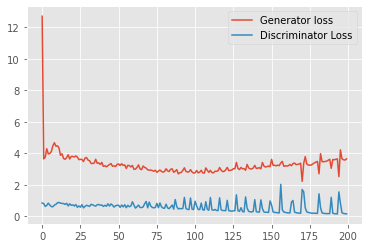

In [ ]:
# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs/loss.png')

In [ ]:
for y in range(0, 1000):
  start_noise = torch.randn(1, nz, 1, 1).to(device)
  stop_noise = torch.randn(1, nz, 1, 1).to(device)
  tensors = []
  for x in range(0, 64):
    tensors.append((float(x)/64.0)*stop_noise+(1-(float(x)/64.0))*start_noise)
  b = torch.Tensor(64, nz, 1, 1).to(device)
  torch.cat(tensors, out=b)
  #saving a reference image
  results = generator(b).detach()
  results = make_grid(results)
  save_image(results, f"linspace/inter{y}.png")